# Deep Learning | Assignment 2 | Part A - Convolutional Neural Networks


**README**

- At the very beginning of this notebook there are helper functions to perform tasks such as extracting the data or visualize it. This notebook also contains two main classes `Library` and `Runner`. `Library` has custom-design CNN models that are trained throughout the code. `Runner` is a training framework for the networks and allows a variety of parameters.

- We re-trained the CNNs setting `verbose=0` to make this notebook more readable before submitting it. Regardless, feel free to set it to 1 at any time to experiment with the models and track training/validation accuracy/loss in real-time. 


In [4]:
%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import h5py
import matplotlib.pyplot as plt

# Algorithm for Ensemble and Stacking
from sklearn.ensemble import RandomForestClassifier

from google.colab import drive
from google.colab import files

plt.style.use("default") # Set default layout for matplotlib's charts

print('All modules imported correctly')
print('Running TensorFlow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


All modules imported correctly
Running TensorFlow version: 2.2.0-rc4


In [5]:
# Mounting Google Drive from Colab to access the flowers dataset
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [6]:
# Unzip and extract the file
!unzip "/content/gdrive/My Drive/Colab Notebooks/data.h5.zip"

Archive:  /content/gdrive/My Drive/Colab Notebooks/data.h5.zip
replace data1.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
!ls

data1.h5  gdrive  sample_data


**Helper functions for this notebook:**

In [0]:
def loadDataH5():
  
  """ This function is given in the assignment spefication document:
  Read training and test data into NumPy arrays from a .h5 file. """

  with h5py.File('data1.h5', 'r') as hf:

    # Extract the data from the .h5 file
    trainX = np.array(hf.get('trainX'))
    trainY = np.array(hf.get('trainY'))
    valX = np.array(hf.get('valX'))
    valY = np.array(hf.get('valY'))

    # Print shape of the arrays
    print('Shape of the training array: \n', trainX.shape)
    print('Shape of the validation array: \n', valX.shape)
  
  return trainX, trainY, valX, valY

def plot_training_data(training_container, n_epochs, model_name=None, save_fig=False):

  """ Visualize the learning curves of a Neural Network.
  Plot up to 5 different metrics.  """
  
  # Get the keys of the container (metrics to be plotted)
  metrics = list(training_container.history.keys())
  # Map metrics to reporting names in charts 
  metrics_mapping = {'loss': 'Training Loss', 'accuracy': 'Training Accuracy', 
                     'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'}
  # Support for 5 different colors
  colors = ['dimgray', 'steelblue', 'salmon', 'darkseagreen', 'violet']

  if len(metrics) > 5:
    raise ValueError('This function can only plot up to 5 metrics.')
  
  # Plot a single linechart with all the training metrics
  plt.figure(figsize = (7,6))
  for metric in range(len(metrics)):
    plt.plot(np.arange(0, n_epochs), training_container.history[metrics[metric]], 
             label=metrics_mapping[metrics[metric]], color=colors[metric])
    #plt.xticks(range(0,n_epochs), range(1,n_epochs+1))
    
  plt.legend()
  if model_name:
    plt.title("Training Loss and Accuracy: {}".format(model_name))
  else:
    plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")

  if save_fig:
    plt.savefig('training_data.png', dpi=400, bbox_inches='tight')
    files.download('training_data.png')

  plt.show()

def plot_models_loss(models, labels, loss='Validation', save_fig=False):
  
  """ Plot a linechart that compares the loss of a selection of 
  models at different training stages. """

  # Supporting up to 5 models and colors
  colors = ['dimgray', 'salmon', 'steelblue', 'darkseagreen', 'violet']
  if len(models) > 5:
      raise ValueError('This function can only plot up to 5 models.')

  if loss == 'Validation':
    requested = 'val_loss'
  elif loss == 'Training':
    requested = 'loss'
  else:
    raise ValueError('Please pick one of the following: Validation, Training.')

  l = 0 # Counter to select colors and labels      
  plt.figure(figsize = (7,6))
  for _model_ in models:
    plt.plot(_model_.history[requested], label=labels[l], color=colors[l])
    l += 1
  plt.xlabel('Epoch #')
  plt.ylabel('Loss')
  plt.title('{} Loss'.format(loss))
  plt.legend()
  
  if save_fig:
    plt.savefig('models_loss.png', dpi=400,  bbox_inches='tight')
    files.download('models_loss.png' )

  plt.show()

def print_best_model(history):

  """ Given a Keras history object, find the model with the lowest 
  validation loss and print level of accuracy and loss. """

  best_model = np.argmin(history.history['val_loss'])
  print('Best model => train loss', history.history['loss'][best_model])
  print('Best model => train accuracy', history.history['accuracy'][best_model])
  print('Best model => validation loss', history.history['val_loss'][best_model])
  print('Best model => validation accuracy', history.history['val_accuracy'][best_model])

**Quick exploratory analysis:**

In [8]:
trainX, trainY, valX, valY = loadDataH5()

Shape of the training array: 
 (1020, 128, 128, 3)
Shape of the validation array: 
 (340, 128, 128, 3)


In [9]:
# Check images are normalized
print("Maximum values of each image's layer: First {f}, Second {s}, Third {t}"\
      .format(f=trainX[:,:,:,0].max(), s=trainX[:,:,:,1].max(), t=trainX[:,:,:,2].max()))
print("Minimum values of each image's layer: First {f}, Second {s}, Third {t}"\
      .format(f=trainX[:,:,:,0].min(), s=trainX[:,:,:,1].min(), t=trainX[:,:,:,2].min()))

Maximum values of each image's layer: First 1.0, Second 1.0, Third 1.0
Minimum values of each image's layer: First 0.0, Second 0.0, Third 0.0


In [10]:
# Store shape
height = trainX.shape[1]
width = trainX.shape[2]
depth = trainX.shape[3]
# There are 17 different classes that are equally distributed in the training set:
unique_classes, count = np.unique(trainY, return_counts=True)
n_classes = len(unique_classes)
print('Number of classes:', n_classes)
print('Class labels: ', unique_classes)
print('Number of training instances per class: ', count)

Number of classes: 17
Class labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Number of training instances per class:  [61 64 60 60 64 62 62 59 53 58 57 57 60 57 61 65 60]


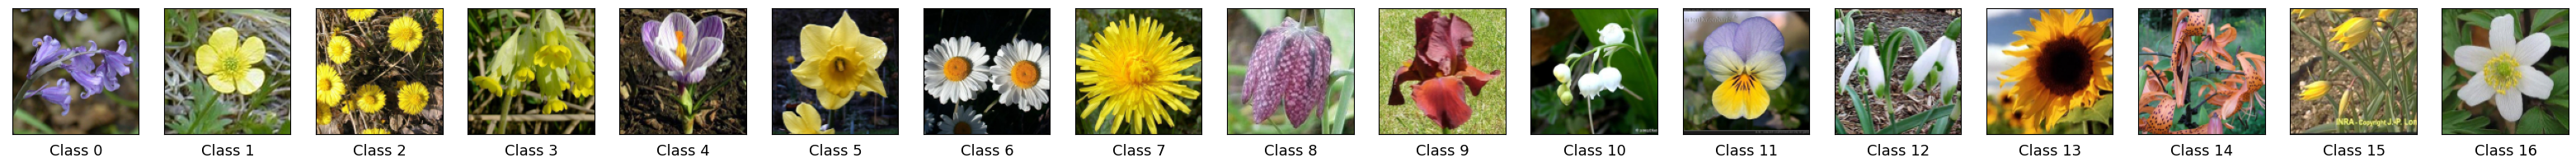

In [11]:
class_examples = []
for class_label in range(0, n_classes):
  class_examples.append(np.random.choice(np.where(trainY == class_label)[0], 1))

# Visualize 17 random images of the training set to get a "feel" of our classification problem
f, position = plt.subplots(1, n_classes, figsize=(40,40))

for image in range(n_classes):
  figure = position[image].\
     imshow(trainX[class_examples[image],:][...,::-1].reshape(128, 128, 3))
  # NumPy arrays are stored as BGR instead of RGB, we reverse this with [...,::-1]
  # Hide axes
  figure.axes.get_xaxis().set_visible(False)
  figure.axes.get_yaxis().set_visible(False)
  # Annotate images with the corresponding class labes
  position[image].\
  text(128/2, 145, 'Class {}'.format(trainY[class_examples[image]][0]), fontsize=13,
       horizontalalignment='center', verticalalignment='center')
  
# Uncomment to save images  
#plt.savefig('flowers_examples.png', dpi=400, bbox_inches='tight')
#files.download('flowers_examples.png')

plt.show()

# PART A (i) - Model Building and Data Augmentation

Before start training models, below we implement classes that are frequently used throughout this notebook:

In [0]:
class Runner:

  """ Training framework for CNNs to run experiments designed for Part A (i)
  of the assignment. """

  def __init__(self, trainX, trainY, valX, valY):

    self.trainX = trainX
    self.trainY = trainY
    self.train_inst = trainX.shape[0]
    self.val_inst = valX.shape[0]
    self.valXY = (valX, valY)

  @staticmethod
  def check_build(model):

    """ Try to print a Keras model's summary or return an error if not possible. """

    try: 
      # Try to print a summary of an existing model
      print(model.summary())
    except Exception as ex:
      # Print the error if the call above failed
      print('Model does not exist. Error found: {e}'.format(e=ex))
    else:
      # Finish a successful Try with a message
      print('\033[1m' + 'Model was successfully built.' + '\033[0m')

    
  def create_data_augmentator(self, strategy):

    """ Create a stochastic generator of images to compose new aritifcial 
    training data based on a set of given parameters. Tensors are expected to 
    have shape `channels_last`. """

    if strategy == 'zoom':
      # This relates to configuration #1 in the report
          generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0, width_shift_range=0, shear_range=0, 
        zoom_range=0.4, horizontal_flip=False, vertical_flip=False,
        data_format='channels_last'
        )
    elif strategy == 'flip':
      # This relates to configuration #2 in the report
      generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0, width_shift_range=0, shear_range=0, 
        zoom_range=0, horizontal_flip=True, vertical_flip=True,
        data_format='channels_last'
        )
    elif strategy == 'all':
      # This relates to configuration #3 in the report
      generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=200, width_shift_range=0.2, shear_range=0.2, 
        zoom_range=0.4, horizontal_flip=True, vertical_flip=True,
        data_format='channels_last'
        )

    return generator

  @staticmethod
  def create_checkpoint(model, monitor, mode):

    """ Create a checkpoint object to pass it through a fit function as an argument.
    The weights of the model are stored in a hdf5 file named after the model's
    name. Only the best models found are stored by default to avoid memory 
    overload. """

    # Path to a generic folder in our drive account (change if needed)
    path = '/content/gdrive/My Drive/Colab Notebooks/'
    # Use model's name as identificator
    fname = path + "{name}.hdf5".format(name=model.name)
    # Create callback function
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        fname, monitor=monitor, mode=mode, save_best_only=True, verbose=1)
    
    return checkpoint

  def fit_model(self, model, lr=0.01, epochs=20, batch_size=32, data_aug=False,
                aug_strategy='all', checkpoint=[], verbose=1):

    """ Run a given algorithm and fit the model. Checkpoint's default value
    is an empty list meaning that `model.fit` function won't store the weights 
    until a proper callback is passed. """
    
    # Stochastic Gradient Descent as optimizer, learning rate is tunable
    optimizer = tf.keras.optimizers.SGD(lr=lr)
    # Checkpoint callback function passed as an argument
    checkpoint = checkpoint
    # Compile the model specifying a loss function, optimizer and target metric 
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, 
        metrics=["accuracy"])
    if data_aug:
      # When data augmentation is set to True, a generator will create 
      # artificial images based samples of training images during the optimization 
      generator = self.create_data_augmentator(aug_strategy)
      history = model.fit(
          x=generator.flow(trainX, trainY, batch_size=batch_size), 
          validation_data=self.valXY, epochs=epochs,
          steps_per_epoch=self.train_inst // batch_size, 
           verbose=verbose, callbacks=[checkpoint]
          )
    else:
      # If data augmentation is set to False, the algorithm is trained 
      # using the original training images
      history = model.fit(
          x=self.trainX, y=self.trainY, validation_data=self.valXY,
          batch_size=batch_size, epochs=epochs, verbose=verbose, 
          callbacks=[checkpoint]
          )
      
    if checkpoint:
      # Load latest stored weights of the model - not necessarily latest model
      path = '/content/gdrive/My Drive/Colab Notebooks/'
      model.load_weights(path + model.name + '.hdf5')
      # Predict on validation set 
      probs = model.predict(self.valXY[0])
      # Compare true values and predicted class 
      bool_acc = tf.math.equal(self.valXY[1], tf.argmax(probs, axis=1))
      # Calculate level of accuracy
      acc = tf.math.divide(tf.math.count_nonzero(bool_acc), self.valXY[1].shape[0])
    else:
      # Calculate level of accuracy of the latest model
      acc = model.evaluate(self.valXY[0], self.valXY[1])
      # Store softmax probabilities 
      probs = model.predict(self.valXY[0])

    return history, acc, probs

In [0]:
class Library:

  """ A collection of Convolutional Neural Networks specifically design for
  Part A of the assignment. It includes a baseline model and 6 additional 
  deeper CNNs. """

  @staticmethod
  def BaselineModel(height, width, depth, n_classes):

    """ About this architecture:
           - 8,390,673 total trainable parameters.
           - ReLu Activation
           - Padding: Yes
           - x1 Convolutions
           - x1 Pooling
           - x1 Fully-Connected
           - x1 Softmax
           """

    # Create instance of the model
    model = tf.keras.Sequential(name='BaselineModel')
    # Determine input shape as a tuple
    input_shape = (height, width, depth)
    # Add layers:
    model.add(tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(
        units=n_classes, activation='softmax'))
    
    # Check if build was successful
    Runner.check_build(model)

    return model

  @staticmethod
  def ModelMK1(height, width, depth, n_classes):

    """ About this architecture:
           - 18,337,425 total trainable parameters.
           - ReLu Activation
           - Padding: Yes
           - x4 Convolutions
           - x4 Pooling
           - x1 Fully-Connected
           - x1 Softmax
           """

    # Create instance of the model
    model = tf.keras.Sequential(name='ModelMK1')
    # Determine input shape as a tuple
    input_shape = (height, width, depth)
    # Add layers:
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=512, activation='relu'))
    model.add(tf.keras.layers.Dense(
        units=n_classes, activation='softmax'))
    
    # Check if build was successful
    Runner.check_build(model)

    return model

  @staticmethod
  def ModelMK2(height, width, depth, n_classes):

    """ About this architecture:
           - 33,998,257 total trainable parameters.
           - ReLu Activation
           - Padding: Yes
           - x6 Convolutions
           - x3 Pooling
           - x1 Fully-Connected
           - x1 Softmax
           """

    # Create instance of the model
    model = tf.keras.Sequential(name='ModelMK2')
    # Determine input shape as a tuple
    input_shape = (height, width, depth)
    # Add layers:
    model.add(tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=512, activation='relu'))
    model.add(tf.keras.layers.Dense(
        units=n_classes, activation='softmax'))
    
    # Check if build was successful
    Runner.check_build(model)

    return model

  @staticmethod
  def ModelMK3(height, width, depth, n_classes):

    """ About this architecture:
           - 38,386,513 total trainable parameters.
           - ReLu Activation
           - Padding: Yes
           - x9 Convolutions
           - x4 Pooling
           - x1 Fully-Connected
           - x1 Softmax
           """

    # Create instance of the model
    model = tf.keras.Sequential(name='ModelMK3')
    # Determine input shape as a tuple
    input_shape = (height, width, depth)
    # Add layers:
    model.add(tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=1024, activation='relu'))
    model.add(tf.keras.layers.Dense(
        units=n_classes, activation='softmax'))
    
    # Check if build was successful
    Runner.check_build(model)

    return model


  @staticmethod
  def ModelMK4(height, width, depth, n_classes):

    """ About this architecture:
           - 19,318,193 total trainable parameters.
           - Leaky ReLu Activation
           - Padding: No
           - x6 Convolutions
           - x3 Pooling
           - x1 Fully-Connected
           - x1 Softmax
           """

    # Create instance of the model
    model = tf.keras.Sequential(name='ModelMK4')
    leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.3)
    # Determine input shape as a tuple
    input_shape = (height, width, depth)
    # Add layers:
    model.add(tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=512, activation=leaky_relu))
    model.add(tf.keras.layers.Dense(
        units=n_classes, activation='softmax'))
    
    # Check if build was successful
    Runner.check_build(model)

    return model

  @staticmethod
  def ModelMK5(height, width, depth, n_classes):

    """ About this architecture:
           - 11,285,777 total trainable parameters.
           - Tanh Activation
           - Padding: No
           - x7 Convolutions
           - x4 Pooling
           - x1 Fully-Connected
           - x1 Softmax
           """

    # Create instance of the model
    model = tf.keras.Sequential(name='ModelMK5')
    # Determine input shape as a tuple
    input_shape = (height, width, depth)
    # Add layers:
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation='tanh'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation='tanh'))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation='tanh'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation='tanh'))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation='tanh'))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation='tanh'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding='valid',
        input_shape=input_shape, activation='tanh'))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=1024, activation='tanh'))
    model.add(tf.keras.layers.Dense(
        units=n_classes, activation='softmax'))
    
    # Check if build was successful
    Runner.check_build(model)

    return model

  @staticmethod
  def ModelMK6(height, width, depth, n_classes):

    """ About this architecture:
           - 34,598,417 total trainable parameters.
           - Leaky ReLu Activation
           - Padding: Yes
           - x6 Convolutions
           - x3 Pooling
           - x1 Fully-Connected
           - x1 Softmax
           """

    # Create instance of the model
    model = tf.keras.Sequential(name='ModelMK6')
    leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.3)
    # Determine input shape as a tuple
    input_shape = (height, width, depth)
    # Add layers
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding='same',
        input_shape=input_shape, activation=leaky_relu))
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=512, activation=leaky_relu))
    model.add(tf.keras.layers.Dense(
        units=n_classes, activation='softmax'))
    
    # Check if build was successful
    Runner.check_build(model)

    return model

In [0]:
# Initialize the framework to run experiments
runner = Runner(trainX, trainY, valX, valY)

### Baseline CNN Model

In [20]:
# Build model
baseline_model = Library.BaselineModel(height, width, depth, n_classes)

Model: "BaselineModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8388672   
_________________________________________________________________
dense_3 (Dense)              (None, 17)                1105      
Total params: 8,390,673
Trainable params: 8,390,673
Non-trainable params: 0
_________________________________________________________________
None
Model was successfully built.


In [21]:
# Run algorithm 
hist0, acc0, prob0 = runner.fit_model(
    baseline_model, lr=0.01, epochs=50, batch_size=32, data_aug=False, verbose=0
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist0)

11/11 [==============================] - 0s 5ms/step - loss: 2.1057 - accuracy: 0.5176
Best model => train loss 0.5950492024421692
Best model => train accuracy 0.8235294222831726
Best model => validation loss 1.4994996786117554
Best model => validation accuracy 0.5088235139846802


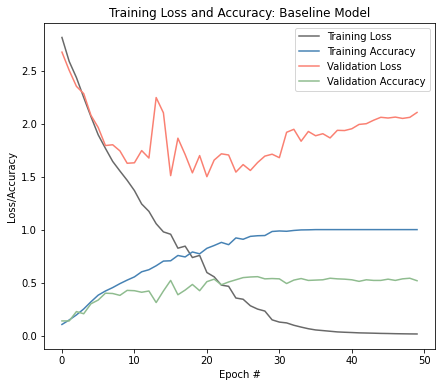

In [22]:
# Plot training data 
plot_training_data(hist0, n_epochs=50, model_name='Baseline Model', save_fig=False)

## Deeper CNN Model Mark-1

In [23]:
# Build model
model_mk1 = Library.ModelMK1(height, width, depth, n_classes)

Model: "ModelMK1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 512)       118

In [24]:
# Run algorithm 
hist1, acc1, prob1 = runner.fit_model(
    model_mk1, lr=0.01, epochs=50, batch_size=32, data_aug=False, verbose=0
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist1)

11/11 [==============================] - 0s 10ms/step - loss: 2.1888 - accuracy: 0.6000
Best model => train loss 0.714031457901001
Best model => train accuracy 0.7627450823783875
Best model => validation loss 1.3945125341415405
Best model => validation accuracy 0.550000011920929


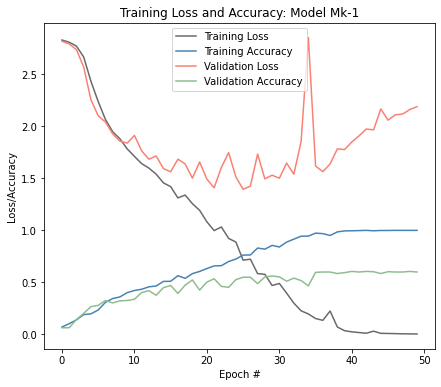

In [25]:
# Plot training data 
plot_training_data(hist1, n_epochs=50, model_name='Model Mk-1', save_fig=False)

## Deeper CNN Model Mark-2

In [28]:
# Build model
model_mk2 = Library.ModelMK2(height, width, depth, n_classes)

Model: "ModelMK2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       738

In [29]:
# Run algorithm 
hist2, acc2, prob2 = runner.fit_model(
    model_mk2, lr=0.01, epochs=50, batch_size=32, data_aug=False, verbose=0
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist2)

11/11 [==============================] - 0s 11ms/step - loss: 4.6331 - accuracy: 0.4794
Best model => train loss 0.8434970378875732
Best model => train accuracy 0.7215686440467834
Best model => validation loss 1.7524622678756714
Best model => validation accuracy 0.48235294222831726


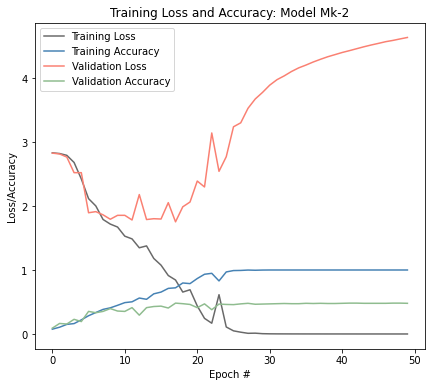

In [30]:
# Plot training data 
plot_training_data(hist2, n_epochs=50, model_name='Model Mk-2', save_fig=False)

## Deeper CNN Model Mark-3

In [31]:
# Build model
model_mk3 = Library.ModelMK3(height, width, depth, n_classes)

Model: "ModelMK3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 128)       0  

In [32]:
# Run algorithm 
hist3, acc3, prob3 = runner.fit_model(
    model_mk3, lr=0.01, epochs=50, batch_size=32, data_aug=False, verbose=0
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist3)

11/11 [==============================] - 0s 22ms/step - loss: 4.6589 - accuracy: 0.4735
Best model => train loss 1.3113468885421753
Best model => train accuracy 0.5558823347091675
Best model => validation loss 1.7877278327941895
Best model => validation accuracy 0.43529412150382996


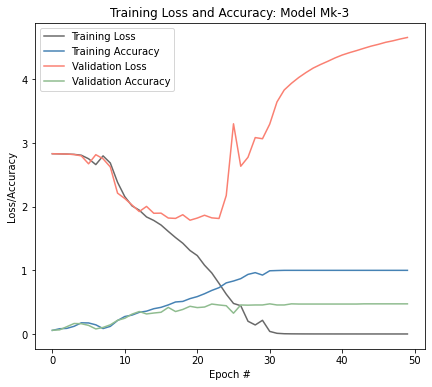

In [34]:
# Plot training data 
plot_training_data(hist3, n_epochs=50, model_name= 'Model Mk-3', save_fig=False)

## Deeper CNN Model MK-2 w/ Data Augmentation

### Configuration #1: Randomly zoom an image up to 50%.

In [35]:
# Build model
model_mk2_aug = Library.ModelMK2(height, width, depth, n_classes)
# Run algorithm
hist2_aug_zoom, acc2_aug_zoom, prob2_aug_zoom = runner.fit_model(
    model_mk2_aug, lr=0.01, epochs=150, batch_size=32,
    data_aug=True, aug_strategy='zoom', verbose=0
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist2_aug_zoom)

Model: "ModelMK2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 128)       738

### Configuration #2:  Randomly flip an image horizontaly and/or vertically.

In [36]:
# Build model
model_mk2_aug = Library.ModelMK2(height, width, depth, n_classes)
# Run algorithm
hist2_aug_flip, acc2_aug_flip, prob2_aug_flip = runner.fit_model(
    model_mk2_aug, lr=0.01, epochs=150, batch_size=32,
    data_aug=True, aug_strategy='flip', verbose=0
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist2_aug_flip)

Model: "ModelMK2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 128)       738

### Configuration #3: Apply a set of techniques at random including configurations #1 and/or #2, along with changes in an image's width and/or orientation by rotating it or shearing it. 



In [143]:
# Build model
model_mk2_aug = Library.ModelMK2(height, width, depth, n_classes)

############################################################
# This is the configuration with highest level of accuracy on 
# the validation set. We store its weights using checkpoint
# so that we can load it later on for the ensemble
###########################################################

# Use checkpoint to store weights of the best model
model_mk2_checkpoint = runner.create_checkpoint(
    model_mk2_aug, monitor='val_loss', mode='min')

# Run algorithm
hist2_aug_all, acc2_aug_all, prob2_aug_all = runner.fit_model(
    model_mk2_aug, lr=0.01, epochs=150, batch_size=32,
    data_aug=True, aug_strategy='all', verbose=0,
    checkpoint=model_mk2_checkpoint
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist2_aug_all)

Model: "ModelMK2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_179 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 32, 32, 128)       738

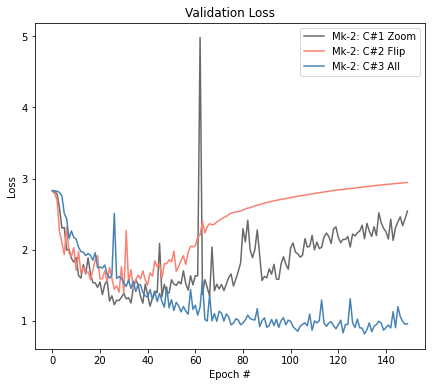

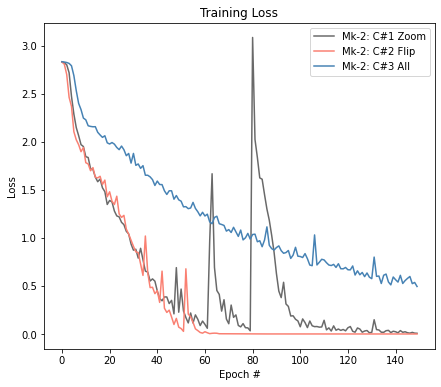

In [40]:
# Select all the previous configurations to plot the data and compare the results 
models = [hist2_aug_zoom, hist2_aug_flip, hist2_aug_all]
labels = ['Mk-2: C#1 Zoom', 'Mk-2: C#2 Flip', 'Mk-2: C#3 All']
# Plot validation loss
plot_models_loss(models, labels, loss='Validation', save_fig=False)
# Plot training loss
plot_models_loss(models, labels, loss='Training', save_fig=False)

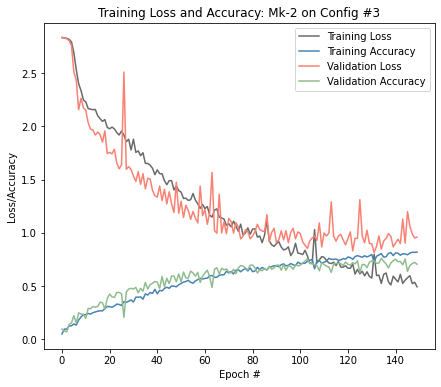

In [41]:
# Plot best model (Configuration 3)
plot_training_data(hist2_aug_all, model_name='Mk-2 on Config #3', n_epochs=150, save_fig=False)

## Deeper CNN Model MK-3 w/ Data Augmentation

### Configuration #1: Randomly zoom an image up to 50%.

In [42]:
# Build model
model_mk3_aug = Library.ModelMK3(height, width, depth, n_classes)
# Run algorithm
hist3_aug_zoom, acc3_aug_zoom, prob3_aug_zoom = runner.fit_model(
    model_mk3_aug, lr=0.01, epochs=150, batch_size=32,
    data_aug=True, aug_strategy='zoom', verbose=0
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist3_aug_zoom)

Model: "ModelMK3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 128)       0  

### Configuration #2:  Randomly flip an image horizontaly and/or vertically.

In [43]:
# Build model
model_mk3_aug = Library.ModelMK3(height, width, depth, n_classes)
# Run algorithm
hist3_aug_flip, acc3_aug_zoom, prob3_aug_zoom = runner.fit_model(
    model_mk3_aug, lr=0.01, epochs=150, batch_size=32,
    data_aug=True, aug_strategy='flip', verbose=0
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist3_aug_flip)

Model: "ModelMK3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 32, 128)       0  

### Configuration #3: Apply a set of techniques at random including configurations #1 and/or #2, along with changes in an image's width and/or orientation by rotating it or shearing it. 

In [186]:
# Build model
model_mk3_aug = Library.ModelMK3(height, width, depth, n_classes)

############################################################
# This is the configuration with highest level of accuracy on 
# the validation set. We store its weights using checkpoint
# so that we can load it later on for the ensemble
###########################################################

# Use checkpoint to store weights of the best model
model_mk3_checkpoint = runner.create_checkpoint(
    model_mk3_aug, monitor='val_loss', mode='min')

# Run algorithm
hist3_aug_all, acc3_aug_zoom, prob3_aug_zoom = runner.fit_model(
    model_mk3_aug, lr=0.01, epochs=150, batch_size=32,
    data_aug=True, aug_strategy='all', verbose=0,
    checkpoint=model_mk3_checkpoint
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist3_aug_all)

Model: "ModelMK3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_343 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_344 (Conv2D)          (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_345 (Conv2D)          (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_346 (Conv2D)          (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_347 (Conv2D)          (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 32, 32, 128)       0  

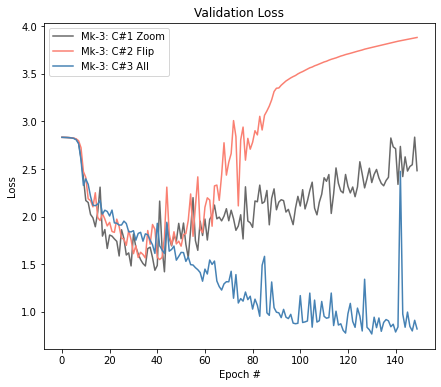

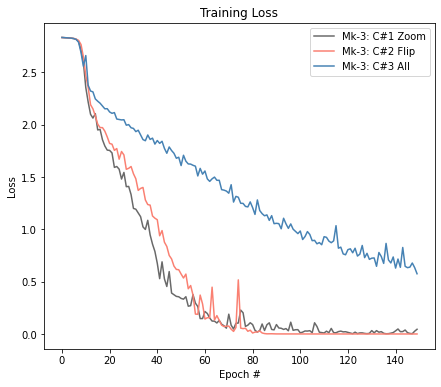

In [45]:
# Select all the previous configurations to plot the data and compare the results 
models = [hist3_aug_zoom, hist3_aug_flip, hist3_aug_all]
labels = ['Mk-3: C#1 Zoom', 'Mk-3: C#2 Flip', 'Mk-3: C#3 All']
# Plot validation loss
plot_models_loss(models, labels, loss='Validation', save_fig=False)
# Plot training loss
plot_models_loss(models, labels, loss='Training', save_fig=False)

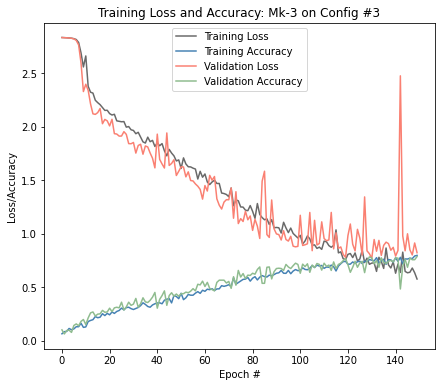

In [46]:
# Plot best model (Configuration 3)
plot_training_data(hist3_aug_all, model_name='Mk-3 on Config #3', n_epochs=150, save_fig=False)

# PART A (ii) - CNN Ensemble

For the ensemble we use models Mk-2 and Mk-3 using the best data augmentation configuration (#3). Additionally, we also use models Mk-4, Mk-5, and Mk-6 under the same augmentation settings. Thus, as Mk-2 and Mk-3 have been already stored, we firstly train Mk-4, Mk-5, and Mk-6 using checkpoint to store their weights. Then, we build the ensemble and run experiments. 

## Deeper CNN Model MK-4 w/ Data Augmentation (Config #3)

In [113]:
# Build model
model_mk4_aug = Library.ModelMK4(height, width, depth, n_classes)
# Use checkpoint to store weights of the best model
model_mk4_checkpoint = runner.create_checkpoint(
    model_mk4_aug, monitor='val_loss', mode='min')
# Run algorithm 
hist4_aug, acc4_aug, prob4_aug = runner.fit_model(
    model_mk4_aug, lr=0.01, epochs=100, batch_size=32,
    data_aug=True, aug_strategy='all', verbose=0,
    checkpoint=model_mk4_checkpoint
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist4_aug)

Model: "ModelMK4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 27, 27, 128)       738

## Deeper CNN Model MK-5 w/ Data Augmentation (Config #3)

In [114]:
# Build model
model_mk5_aug = Library.ModelMK5(height, width, depth, n_classes)
# Use checkpoint to store weights of the best model
model_mk5_checkpoint = runner.create_checkpoint(
    model_mk5_aug, monitor='val_loss', mode='min')
# Run algorithm 
hist5_aug, acc5_aug, prob5_aug = runner.fit_model(
    model_mk5_aug, lr=0.01, epochs=100, batch_size=32,
    data_aug=True,  aug_strategy='all', verbose=0,
    checkpoint=model_mk5_checkpoint
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist5_aug)

Model: "ModelMK5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 59, 59, 128)       147584    
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 27, 27, 256)       295168    
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 25, 25, 256)       590

## Deeper CNN Model MK-6 w/ Data Augmentation (Config #3)

In [136]:
# Build model
model_mk6_aug = Library.ModelMK6(height, width, depth, n_classes)
# Use checkpoint to store weights of the best model
model_mk6_checkpoint = runner.create_checkpoint(
    model_mk6_aug, monitor='val_loss', mode='min')
# Run algorithm 
hist6_aug, acc6_aug, prob6_aug = runner.fit_model(
    model_mk6_aug, lr=0.01, epochs=100, batch_size=32,
    data_aug=True,  aug_strategy='all', verbose=0,
    checkpoint=model_mk6_checkpoint
    )
# Print training/validation loss and accuracy of the model 
# with minimum validation loss
print_best_model(hist6_aug)

Model: "ModelMK6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_257 (Conv2D)          (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_258 (Conv2D)          (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_259 (Conv2D)          (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_130 (MaxPoolin (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_260 (Conv2D)          (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_261 (Conv2D)          (None, 32, 32, 256)       295

## Ensemble & Meta-Learner

In [0]:
def ensemble_predict(models, trainX, trainY, load_weights=False):

  """ Make models predict on a set of data. The resulting dataset has as many 
  observations as the original set and as many features as (learners * classes).
  Loading weights is optional in case models already trained are passed. """

  # Initialize an array to store base learners predicted probabilities
  stacking_dataset = tf.constant(trainY.reshape(trainY.shape[0], 1), dtype=tf.float32)

  for model in ensemble:

    if load_weights:
      # Load weights of the models (previously saved with checkpoint) 
      path = '/content/gdrive/My Drive/Colab Notebooks/'
      model.load_weights(path + model.name + '.hdf5')

    # Make the model predict on the training set 
    probs = model.predict(trainX)
    # Row-wise concatenation of probabilities for every base learner
    stacking_dataset = tf.concat([stacking_dataset, probs], axis=-1)

  print('Shape of the resulting database:', stacking_dataset.shape)

  return stacking_dataset

def calculate_accuracy(predicted, actual):

  """ Check the level of accuracy given predicted classes and actual labels. """

  bool_acc = tf.math.equal(predicted, actual)
  accuracy = tf.math.divide(tf.math.count_nonzero(bool_acc), actual.shape[0])

  return accuracy.numpy()

In [0]:
class Ensemble:

  """ Simple class to store an ensemble model and evaluate it. """

  def __init__(self, base_learners, meta_learner):

    self.base_learners = base_learners
    self.meta_learner = meta_learner 

  def perform_stacking(self, x, y):

    """ Create a dataset of probabilities and a meta-learner predicts the 
    final class combining the output of the base-learners. """
    
    # Use the CNNs to create a dataset of probabilities
    probs = ensemble_predict(self.base_learners, x, y, load_weights=False)
    # Predict the final using the meta-learner
    pred = self.meta_learner.predict(probs[:,1:].numpy())
    # Calculate level of accuracy
    accuracy = calculate_accuracy(pred, y)

    return accuracy

  def perform_bagging(self, x, y):

    """ Perform bagging aggregating probabilities of base-learners. 
    It also returns the accuracy of each individual learner."""

    # Initialize a tensor with shape (n_instances, n_classes)
    bagging_probs = tf.zeros(shape=(y.shape[0], len(np.unique(y))))
    # Create an empty list to store each model's accuracy
    learners_accuracy = []

    for model in self.base_learners:
      # Use predict method
      probs = model.predict(x)
      # Predicted class
      pred_class = tf.argmax(probs, axis=1)
      # Store the probabilities 
      bagging_probs += probs
      # Store each learner's accuracy
      learners_accuracy.append(calculate_accuracy(pred_class, y))

    # Average predicted probabilities
    average_prob = bagging_probs / len(self.base_learners)
    # Predicted class
    pred_class = tf.argmax(average_prob, axis=1)
    # Calculate bagging accuracy
    bagging_accuracy = calculate_accuracy(pred_class, y)
    # Create a list containing individual and aggregated accuracy
    accuracy = [bagging_accuracy, learners_accuracy]

    return accuracy

  def evaluate(self, x, y, method):

    """ Evaluate an ensemble using stacking or bagging. """

    if method == 'stacking':
      accuracy = self.perform_stacking(x, y)
    elif method == 'bagging':
      accuracy =  self.perform_bagging(x, y)
    else:
      raise ValueError('Please select one of the following: stacking, bagging.')

    return accuracy

In [177]:
# Re-build models
model_mk2_aug = Library.ModelMK2(height, width, depth, n_classes)
model_mk3_aug = Library.ModelMK3(height, width, depth, n_classes)
model_mk4_aug = Library.ModelMK4(height, width, depth, n_classes)
model_mk5_aug = Library.ModelMK5(height, width, depth, n_classes)
model_mk6_aug = Library.ModelMK6(height, width, depth, n_classes)
# Store all models in the ensemble as a list 
ensemble = [model_mk2_aug, model_mk3_aug, model_mk4_aug, model_mk5_aug, model_mk6_aug]

Model: "ModelMK2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_253 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_254 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_255 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_256 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_257 (Conv2D)          (None, 32, 32, 128)       738

In [178]:
# Create and store training dataset of probabilities
stacking_data = ensemble_predict(ensemble, trainX, trainY, load_weights=True)
# Drop the first column (true class labels)
stacking_training = stacking_data[:,1:].numpy()

Shape of the resulting database: (1020, 86)


In [0]:
# Split the dataset - as it is shuffled, we split the data simply indicating
# an index value
meta_trainX = stacking_training[:800]
meta_trainY = trainY[:800]
meta_testX = stacking_training[800:]
meta_testY = trainY[800:]

In [182]:
# Sub-optimal parameters (not performing hyper-parameter tuning)
rf = RandomForestClassifier(n_estimators=400, random_state=0)
rf.fit(meta_trainX, meta_trainY)

# Check train accuracy
train_pred = rf.predict(meta_trainX)
train_acc = calculate_accuracy(train_pred, meta_trainY)
print('Train Accuracy: ', train_acc)
# Check test accuracy
test_pred = rf.predict(meta_testX)
test_acc = calculate_accuracy(test_pred, meta_testY)
print('Test Accuracy: ', test_acc)

# Train the meta-learner on the entire dataset
rf.fit(stacking_training, trainY)

Train Accuracy:  1.0
Test Accuracy:  0.9136363636363637


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [172]:
# Create an ensemble object
cnn_ensemble = Ensemble(base_learners=ensemble, meta_learner=rf)
# Evaluate the ensemble using stacking
stacking_results = cnn_ensemble.evaluate(valX, valY, method='stacking')
# Evaluate the ensemle using bagging  
bagging_results = cnn_ensemble.evaluate(valX, valY, method='bagging')

Shape of the resulting tabular database: (340, 86)


In [173]:
# Print the results of the ensemble on the validation set
for model in range(len(ensemble)):
  print(ensemble[model].name, 'validation accuracy:', bagging_results[1][model])
print('Bagging average model accuracy:', bagging_results[0])
print('Stacking accuracy:', stacking_results)

ModelMK2 validation accuracy: 0.7323529411764705
ModelMK3 validation accuracy: 0.788235294117647
ModelMK4 validation accuracy: 0.7088235294117647
ModelMK5 validation accuracy: 0.7176470588235294
ModelMK6 validation accuracy: 0.7323529411764705
Bagging average model accuracy: 0.8029411764705883
Stacking accuracy: 0.8205882352941176


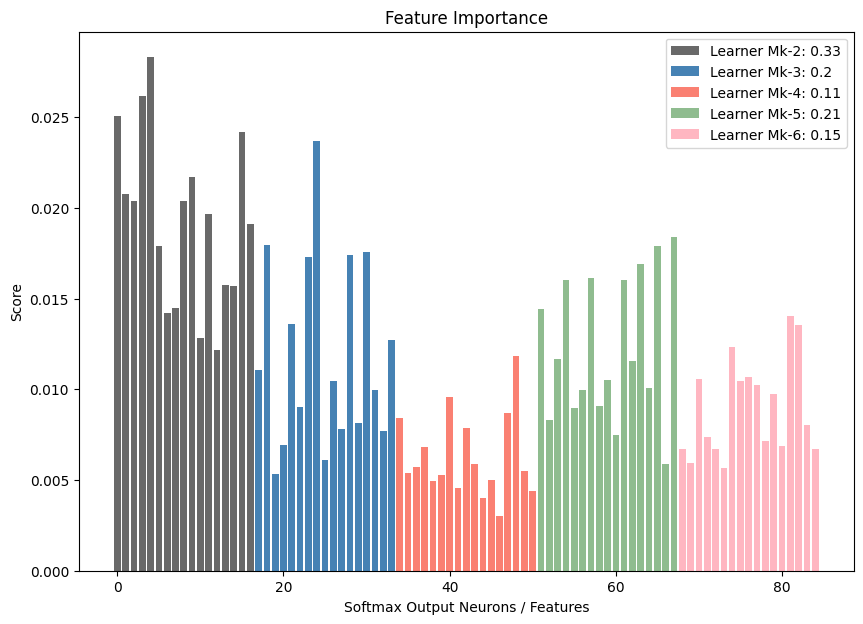

In [174]:
# Plot Randon Forest's feature importance chart. How relevant is each neuron in the 
# softmax layer of the ensemble with respect to the predicted class?

labels = ['Learner Mk-2', 'Learner Mk-3', 'Learner Mk-4', 'Learner Mk-5', 'Learner Mk-6']
colors = ['dimgray', 'steelblue', 'salmon', 'darkseagreen', 'lightpink']
breaks = n_classes * np.array([0,1,2,3,4,5])
plt.figure(figsize=(10,7))

for i in range(1, len(breaks)):
  # Aggregate scores each base-learner (sum importances of all the features
  # relative to one learner)
  imp = round(rf.feature_importances_[breaks[i-1]:breaks[i]].sum(),2)
  # Plot a barchart of each feature, assigning unique colors to each base-learner
  plt.bar(range(breaks[i-1],breaks[i]), rf.feature_importances_[breaks[i-1]:breaks[i]], 
          color=colors[i-1], label=labels[i-1]+ ': '+ str(imp))
  plt.legend()
plt.xlabel('Softmax Output Neurons / Features')
plt.ylabel('Score')
plt.title('Feature Importance');

# Uncomment to save images  
# plt.savefig('feature_importance.png', dpi=400, bbox_inches='tight')
# files.download('feature_importance.png')